# Main script to clean CA fires data

Modules: N/A <br>
Author: Cornelia Ilin & Joy McGillin <br>
Email: cilin@wisc.edu & jmoglia@berkeley.edu <br>
Date created: March 22, 2020 <br>
Date updated: February 2023 <br>

**Citations (data sources)**

``CA fires data:``
1. CAL Fire: Fire perimeters database: https://frap.fire.ca.gov/mapping/gis-data/
2. Data dictionary: https://frap.fire.ca.gov/frap-projects/fire-perimeters/

Layer 0 - accidental wildfires <br>
Layer 1 - prescribed fires <br>
Layer 2 - non-prescribed fire fuel reduction projects <br>

``Shapefiles for California ZIP codes (2010 census):``

Note: CAL Fire also has county bounderies info (check it here: https://frap.fire.ca.gov/mapping/gis-data/)

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas

4. How to find if a point is inside a polygon:<br>
https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon <br>
https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [5]:
# standard
import pandas as pd
import numpy as np
import os
from datetime import datetime

# geospatial
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)

In [12]:
!ls ../wind/tl_2010_06_zcta510

tl_2010_06_zcta510.dbf     tl_2010_06_zcta510.shp.xml
tl_2010_06_zcta510.prj     tl_2010_06_zcta510.shx
tl_2010_06_zcta510.shp


### Step 2: Define working directories

In [64]:
in_dir = 'fire21_2.gdb'
jordan_ZCTA_dir = '../wind/tl_2010_06_zcta510.zip'

### Step 3: Define functions

In [49]:
def clean_fires(gdf, zips,jordan=0):
    '''
    '''
    if jordan:
        col = "ZCTA5CE10"
    else:
        col = "ZCTA"
        
    print(f"Original shape: {gdf.shape}")
    # create a new column for zipcodes. for each fire, add a row for each zipcode within the perimeter
    # ex: if the august complex fire burned in 2 zipcodes, the new dataset would have 2 rows for the same fire 
    gdf = gpd.sjoin(gdf,zips[[col,'geometry']],how='left',op='intersects')
    
    
    # transform CRS EPSG:3310 to CRS EPSG:4269 (the latter is the lat-lon format); 
    # check here: https://residentmario.github.io/geoplot/user_guide/Working_with_Geospatial_Data.html
    # note the health data is in epsg=4269; check here: https://spatialreference.org/ref/epsg/4269/
    gdf = gdf.to_crs(epsg=4269) 
    
    # edit dates for fires with typos in the year
    gdf.loc[19582,"ALARM_DATE"] = '2016-09-26T00:00:00'
    gdf.loc[21138,"ALARM_DATE"] = '2019-05-29T00:00:00'
    gdf.loc[21138,"CONT_DATE"] = '2019-05-29T00:00:00'
    gdf.loc[339,"CONT_DATE"] = '2020-08-20T00:00:00'
    gdf.loc[15460,"CONT_DATE"] = '1989-08-20T00:00:00'
    gdf.loc[21105,"CONT_DATE"] = '2019-08-21T00:00:00'
    gdf.loc[21426,"CONT_DATE"] = '2021-05-06T00:00:00'   #https://www.fire.ca.gov/incidents/2021/5/2/southern-fire/
    
    
    # drop fires with long >= 1year durations-- likely a typo with the CONT_DATE
    gdf.drop(18908, inplace=True) #PIUTE fire from August 1990 with 3319 day duration
    gdf.drop(18803, inplace=True) #Westlake fire July 8, 2006, 33 acres, burned 366 days
    gdf.drop(13124, inplace=True) #LAVAL fire from June 3, 2012, 41 acres burned for 365 days
    gdf.drop(20618, inplace=True)
    gdf.drop(21451, inplace=True)
    
    # drop if STATE is not California, and then drop the column
    gdf = gdf[gdf.STATE=='CA']
    
    
    # drop cols 
    dropcols = ['AGENCY', 'UNIT_ID', 'INC_NUM', 'COMMENTS', 'REPORT_AC', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'STATE', 'YEAR_']
    gdf.drop(dropcols, inplace=True, axis=1)

    
    # drop if ALARM_DATE is NA 
    # note that there are ~5284 null values for alarm date (~24% of the data).
    gdf = gdf[~(gdf.ALARM_DATE.isna())]
    
    print(f"Shape after alarm date nulls dropped: {gdf.shape}")
    
    # drop if CONT_DATE is NA 
    # 
    gdf = gdf[~(gdf.CONT_DATE.isna())]
    
    print(f"Shape after containment date nulls dropped: {gdf.shape}")

    # add fire centroid
    # use Equal area cylindrical projection:
    # https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
    gdf['fire_centroid'] = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
    
    # convert to date-time objects
    gdf['ALARM_DATE'] = pd.to_datetime(gdf['ALARM_DATE'], utc=True)
    gdf['CONT_DATE'] = pd.to_datetime(gdf['CONT_DATE'], utc=True)
    
     # add duration of fire (in days) variable
    gdf["DURATION"]= gdf['CONT_DATE']-gdf['ALARM_DATE']

    
    # add fire geometry area (in KM^2)
    gdf['FIRE_AREA_KM2'] = gdf['geometry'].to_crs('+proj=cea')\
                                 .map(lambda p: p.area / 10**6)
    
    # transform epsg back to 4269
    gdf = gdf.to_crs(epsg=4269)
    print(gdf.shape)
    
    # drop if fire duration days is negative
    gdf = gdf[~(gdf["DURATION"] < np.timedelta64(0,'D'))]

    print(f"Final shape: {gdf.shape}")
    
    return gdf

### Step 4: Read & Clean data

In [39]:
# read in the first layer of fire perimeter data
data = gpd.read_file(in_dir , layer=0)

In [47]:
data.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,COMPLEX_NAME,COMPLEX_INCNUM,geometry
0,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,,110.0,109.602280,1.0,1.0,NaN,3252.523280,4.435447e+05,NaN,NaN,"MULTIPOLYGON (((-116841.251 97942.565, -116836..."
1,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,,670.0,685.585022,1.0,1.0,NaN,9653.760308,2.774464e+06,NaN,NaN,"MULTIPOLYGON (((-117328.400 90212.407, -117321..."
2,2020,CA,CDF,NEU,ATHENS,00018493,2020-08-10T00:00:00+00:00,2020-03-01T00:00:00+00:00,14.0,,26.0,27.300480,1.0,1.0,NaN,1649.643235,1.104811e+05,NaN,NaN,"MULTIPOLYGON (((-115605.059 92988.787, -115585..."
3,2020,CA,CDF,NEU,FLEMING,00007619,2020-03-31T00:00:00+00:00,2020-04-01T00:00:00+00:00,9.0,,13.0,12.931545,1.0,1.0,NaN,1577.155857,5.233211e+04,NaN,NaN,"MULTIPOLYGON (((-110213.270 105975.579, -11020..."
4,2020,CA,CDF,NEU,MELANESE,00008471,2020-04-14T00:00:00+00:00,2020-04-19T00:00:00+00:00,18.0,,10.3,10.315964,1.0,1.0,NaN,1035.787625,4.174722e+04,NaN,NaN,"MULTIPOLYGON (((-111793.600 164243.615, -11177..."


In [65]:
# read in california zipcode data
# https://earthworks.stanford.edu/catalog/stanford-dc841dq9031
# zips = gpd.read_file('ca_zipcode.gdb' , layer=0)

#jordan ZCTA 
zips = gpd.read_file(jordan_ZCTA_dir)

In [66]:
zips.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,06,94601,0694601,B5,G6350,S,8410939,310703,+37.7755447,-122.2187049,N,"POLYGON ((-122.22717 37.79197, -122.22693 37.7..."
1,06,94501,0694501,B5,G6350,S,20539466,9005303,+37.7737968,-122.2781230,N,"POLYGON ((-122.29181 37.76301, -122.30661 37.7..."
2,06,94560,0694560,B5,G6350,S,35757865,60530,+37.5041413,-122.0323587,N,"POLYGON ((-122.05499 37.54959, -122.05441 37.5..."
3,06,94587,0694587,B5,G6350,S,51075108,0,+37.6031556,-122.0186382,N,"POLYGON ((-122.06515 37.60485, -122.06499 37.6..."
4,06,94580,0694580,B5,G6350,S,8929836,17052,+37.6757312,-122.1330170,N,"POLYGON ((-122.12999 37.68445, -122.12995 37.6..."


In [67]:
# clean data and show first 10 rows
data_clean = clean_fires(data, zips,1)

Original shape: (21688, 20)
Shape after alarm date nulls dropped: (16238, 10)
Shape after containment date nulls dropped: (8991, 10)
(8991, 13)
Final shape: (8961, 13)


In [89]:
# for idx, missing in data_clean[data_clean["ZCTA5CE10"].isna()].iterrows():
#     for _, zcta in zips.iterrows():
#         if pointzips["ZCTA5CE10"]

In [ ]:
data_clean[data_clean["FIRE_NAME"] == "AUGUST COMPLEX"]

### Step 5: Save Dropped Data into new CSV

In [ ]:
# dropped_fires = [18908,18803,13124,20618,21451]
# data_dropped = pd.DataFrame()


In [ ]:
# for x in dropped_fires:
#     data_dropped = data_dropped.append(data.loc[x], ignore_index=True)

In [ ]:
# fires without alarm or containment dates
# data_dropped = data_dropped.append(data.loc[pd.isnull(data[['ALARM_DATE', 'CONT_DATE']]).any(axis=1)], ignore_index=True)

In [ ]:
# dropcols = ['AGENCY', 'UNIT_ID', 'INC_NUM', 'COMMENTS', 'REPORT_AC', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'STATE', 'YEAR_']
# data_dropped.drop(dropcols, inplace=True, axis=1)

In [ ]:
# data_dropped['FIRE_AREA_KM2'] = data_dropped['geometry'].to_crs('+proj=cea')\
#                                  .map(lambda p: p.area / 10**6)

In [ ]:
# data_dropped = data_dropped.to_crs(epsg=4269)

In [ ]:
# data_dropped

(-124.92351000000001,
 -113.61729199999999,
 32.055148448232686,
 42.593314587113454)

<Figure size 1000x1000 with 0 Axes>

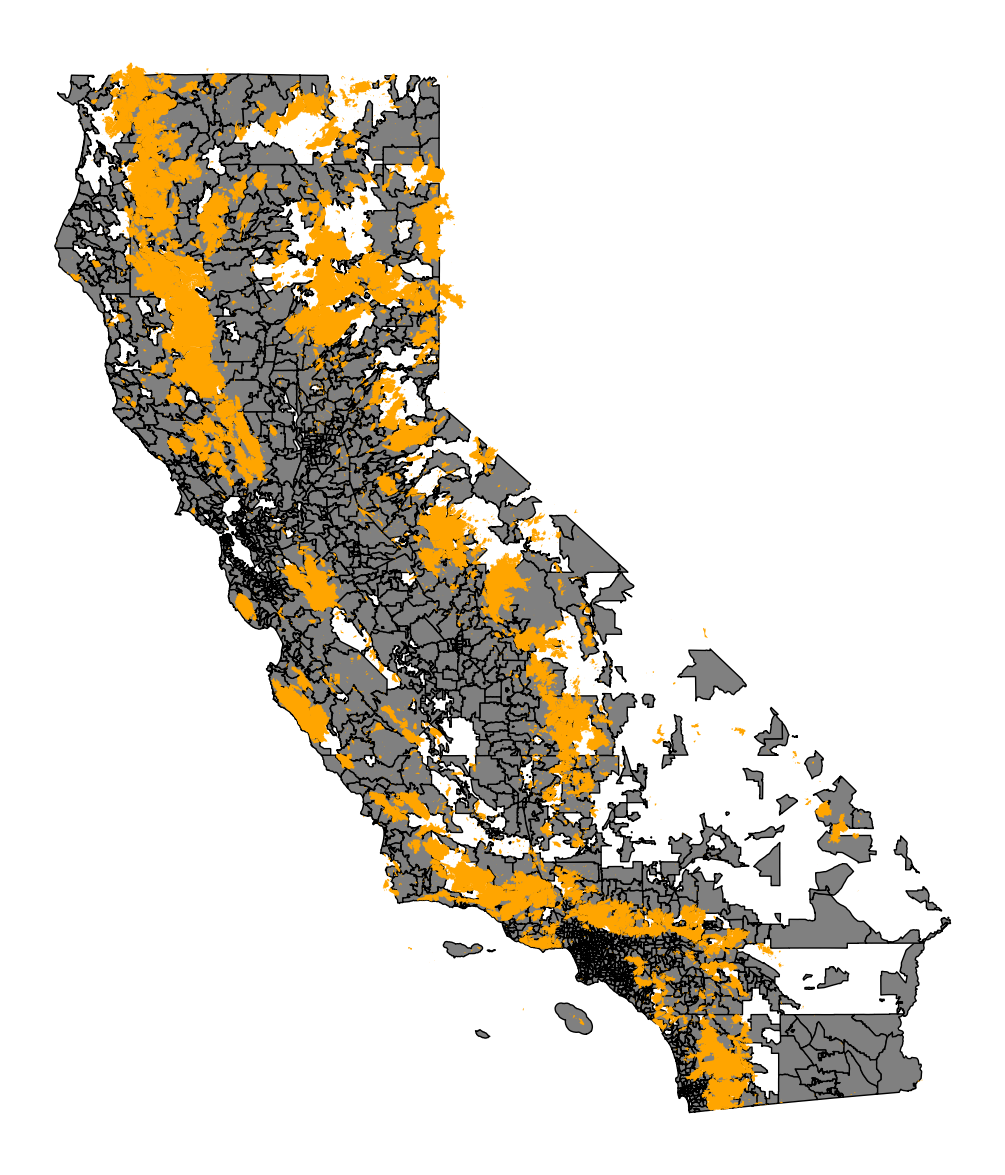

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
# plot base


fig, ax = plt.subplots(1, 1, figsize=(15,15))

zips.plot(
    ax=ax,
    cmap=None,
    edgecolor='k',
    facecolor='grey'
)

data_clean.geometry.plot(
    ax=ax,
    facecolor='orange',
)
# set axis off
ax.axis("off")

# plt.savefig(out_dir + "Fig3c.pdf")

### Step 6: Export to .csv

In [ ]:
data_clean.to_csv('fires_clean_with_zipcodes.csv', index_label='Index')

In [ ]:
# data_dropped.to_csv('fires_dropped.csv', index_label='Index')